In [1]:
import arctic
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import tiledb
import pandas as pd
import numpy as np
import timeit
import tiledb
#import dask, dask.array as da
#from dask.dataframe import from_pandas

/Users/inorton/work/scratch/20210728-slack-benchmark/venv/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Connect to the mongo-host / cluster
store = arctic.Arctic("127.0.0.1")

store.list_libraries()

# Create a library
store.initialize_library('benchmark')

# Get a library
library = store['benchmark']
print(library.list_symbols())
for symbol in library.list_symbols():
    print("deleting", symbol)
    library.delete(symbol)

Library created, but couldn't enable sharding: no such command: 'enablesharding', full error: {'ok': 0.0, 'errmsg': "no such command: 'enablesharding'", 'code': 59, 'codeName': 'CommandNotFound'}. This is OK if you're not 'admin'


[]


In [3]:
period_ends = ["1970-01-01", "1990-01-01","2020-01-01","2030-01-01"]


columns = [list("abcdefgh")]

idx = pd.date_range(start="1960-01-01", end="1970-01-01", freq="H")
df = pd.DataFrame(data=np.random.uniform(0, 10000, size=(len(idx),8)), index=idx, columns=columns)

In [4]:
stats_list = []

for i in range(100):
    for end in period_ends:
        idx = pd.date_range(start="1960-01-01", end=end, freq="H")
        df = pd.DataFrame(data=np.random.uniform(0, 10000, size=(len(idx),8)), index=idx, columns=columns, dtype=np.float64)
        starttime = timeit.default_timer()
        library.write(f"""df_{end}_{i}""", df)
        time_diff = timeit.default_timer() - starttime
        stats_list.append([len(idx), time_diff])

In [5]:
arctic_write_stats = pd.DataFrame(data=stats_list,columns=["length", "time"])
arctic_write_stats

,length,time
0,87673,0.112031
1,262993,0.214016
2,525961,0.463859
3,613633,0.544670
4,87673,0.072992
...,...,...
395,613633,0.529247
396,87673,0.079253
397,262993,0.237647
398,525961,0.529512


In [6]:
arctic_write_stats.time.sum()

139.91948187999992

<AxesSubplot:xlabel='length', ylabel='time'>

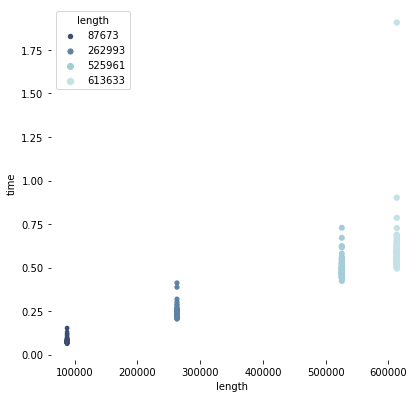

In [7]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="length", y="time",
                hue="length", size="length",
                palette="ch:r=-.2,d=.3_r",
                #hue_order=period_ends,
                sizes=(20, 40), linewidth=0,
                data=arctic_write_stats, ax=ax)

In [9]:
stats_list = []


for i in range(100):
    for end in period_ends:
        #idx = pd.date_range(start="1960-01-01", end=end, freq="H")
        #idx = idx.strftime('%Y-%m-%d')
        #df = pd.DataFrame(data=np.random.uniform(0, 10000, size=(len(idx),8)), columns=columns).to_numpy()
        dim = tiledb.Dim(name='date',
                 domain=(np.datetime64('1960-01-01'), np.datetime64(end)),
                 #tile=np.timedelta64(24, 'h'),
                 tile=np.timedelta64(365*24, 'h'),      
                 dtype=np.datetime64('', 'h').dtype)
        dom = tiledb.Domain(dim)
        schema = tiledb.ArraySchema(domain=dom,
                                    attrs=[
                                        tiledb.Attr('a', dtype=np.float64),
                                        tiledb.Attr('b', dtype=np.float64),
                                        tiledb.Attr('c', dtype=np.float64),
                                        tiledb.Attr('d', dtype=np.float64),
                                        tiledb.Attr('e', dtype=np.float64),
                                        tiledb.Attr('f', dtype=np.float64),
                                        tiledb.Attr('g', dtype=np.float64),
                                        tiledb.Attr('h', dtype=np.float64),],
                                   )
        # Randomly generate 2 years of values for attribute 'a'
        idx = pd.date_range(start="1960-01-01", end=end, freq="H")
        a_vals = np.random.rand(len(idx))
        b_vals = np.random.rand(len(idx))
        c_vals = np.random.rand(len(idx))
        d_vals = np.random.rand(len(idx))
        e_vals = np.random.rand(len(idx))
        f_vals = np.random.rand(len(idx))
        g_vals = np.random.rand(len(idx))
        h_vals = np.random.rand(len(idx))
        
        # Write the data at the beginning of the domain.
        start = np.datetime64('1960-01-01')
        end = start + np.timedelta64(len(idx) - 1, 'h')

        starttime = timeit.default_timer()
        tiledb.Array.create(f"""data/df_{end}_{i}""", schema)
        with tiledb.open(f"""data/df_{end}_{i}""", 'w') as T:
            T[start: end] = {
                'a': a_vals,
                'b': b_vals,
                'c': c_vals,
                'd': d_vals,
                'e': e_vals,
                'f': f_vals,
                'g': g_vals,
                'h': h_vals
            }
        time_diff = timeit.default_timer() - starttime
        stats_list.append([len(idx), time_diff])


In [10]:
tile_write_stats = pd.DataFrame(data=stats_list,columns=["length", "time"])
tile_write_stats

,length,time
0,87673,0.048838
1,262993,0.079331
2,525961,0.186390
3,613633,0.171776
4,87673,0.064278
...,...,...
395,613633,0.147185
396,87673,0.039241
397,262993,0.072063
398,525961,0.130718


In [11]:
tile_write_stats.time.sum()

42.129046016999894

<AxesSubplot:xlabel='length', ylabel='time'>

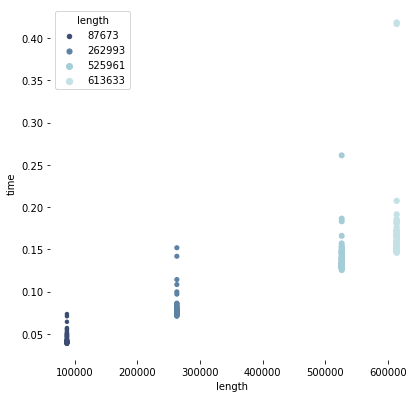

In [12]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="length", y="time",
                hue="length", size="length",
                palette="ch:r=-.2,d=.3_r",
                #hue_order=period_ends,
                sizes=(20, 40), linewidth=0,
                data=tile_write_stats, ax=ax)

In [20]:
arctic_write_stats[arctic_write_stats.length == 613633].time.max()

1.9076976529999854

In [22]:
tile_write_stats[tile_write_stats.length == 613633].time.max()

0.41837326200004554